In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
# Program bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
pynrc.setup_logging('WARN', verbose=True)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [4]:
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
from pynrc.reduce.ref_pixels import NRC_refs

In [5]:
# from pynrc import speckle_noise as sn
from astropy.io import fits, ascii

In [6]:
from pynrc.nrc_utils import hist_indices, binned_statistic
from pynrc.nrc_utils import jl_poly_fit, jl_poly, pad_or_cut_to_size, rotate_offset

In [7]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

[0.97278248]


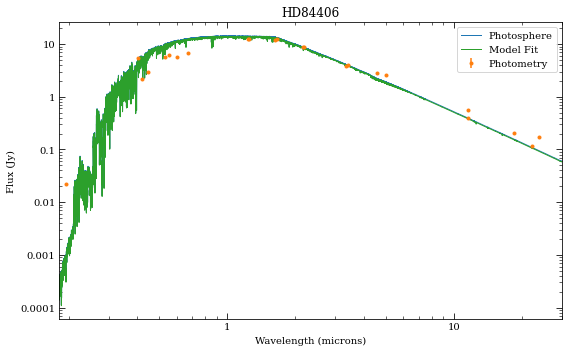

In [70]:
from pynrc.nrc_utils import source_spectrum

vot = votdir + 'HD84406.vot'

bp_k = pynrc.bp_2mass('k')
mag_k = 4.7

args = ('HD84406', 'K0V', mag_k, bp_k, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=True, robust=False, wlim=[1,10])

# Final source spectrum
sp_sci = src.sp_model

fig, ax = plt.subplots(1,1, figsize=(8,5))
src.plot_SED(ax=ax, xr=[0.18,30])

fig.tight_layout()

In [75]:
bp_lw = pynrc.read_filter('F322W2', pupil='GRISMR', ice_scale=0, nvr_scale=0)

sp_types = ['G0V', 'G3V', 'G5V', 'K0V', 'K3V', 'K5V']
flux_arr = []
for spt in sp_types:

    if spt=='K5V':
        spt = 'K4V'
        
    sp = pynrc.stellar_spectrum(spt, 4.7, 'vegamag', bp_k)
    obs = S.Observation(sp, bp_lw, binset=bp_lw.wave)
    obs.convert('counts')
    flux_arr.append(obs.binflux)

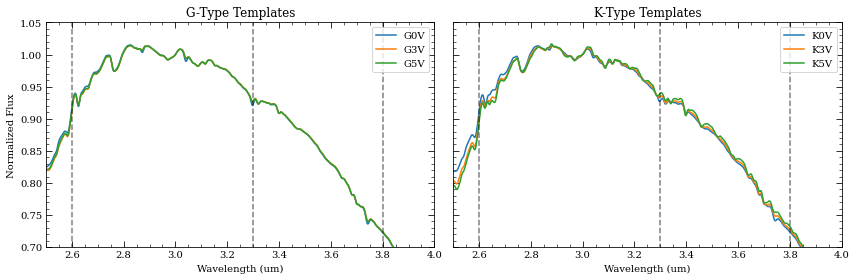

In [81]:
import scipy

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

w = nrc_utils.frebin(obs.binwave/1e4, dimensions=1000, total=False)
for i, f in enumerate(flux_arr):
    spt = sp_types[i]
    if 'G' in spt:
        ax = axes[0]
    elif 'K' in spt:
        ax = axes[1]
    
    f_smth = scipy.ndimage.gaussian_filter(f, 5)
    f_smth = f_smth / np.interp(3, obs.binwave/1e4, f_smth)
    f_rebin = nrc_utils.frebin(f_smth, dimensions=1000, total=False)
    ax.plot(w, f_rebin, label=spt)

for ax in axes:
    ax.plot([2.6,2.6], [0,2], ls='--', color='k', alpha=0.5)
    ax.plot([3.3,3.3], [0,2], ls='--', color='k', alpha=0.5)
    ax.plot([3.8,3.8], [0,2], ls='--', color='k', alpha=0.5)
    
for ax in axes:
    ax.set_xlim([2.5, 4])
    ax.set_ylim([0.7,1.05])
    ax.set_xlabel('Wavelength (um)')
    ax.legend()

axes[0].set_ylabel("Normalized Flux")
axes[0].set_title('G-Type Templates')
axes[1].set_title('K-Type Templates')
    
fig.tight_layout()